In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL
from diffusers import BitsAndBytesConfig
from diffusers import StableDiffusionInpaintPipeline
from diffusers import UNet2DConditionModel
from PIL import Image

torch.backends.cuda.matmul.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float16

model_version = "stabilityai/stable-diffusion-2-inpainting"
DCS = False
username = "sneakers-pretrained-models"
if DCS:
  models_path = f"/dcs/large/{username}"
else:
  models_path = None

# nf4_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=dtype,
# )
# unet_nf4 = UNet2DConditionModel.from_pretrained(
#     model_version,
#     subfolder="unet",
#     quantization_config=nf4_config,
#     torch_dtype=dtype,
#     use_safetensors=True,
#     cache_dir=models_path,
# )

# vae_nf4 = AutoencoderKL.from_pretrained(
#     model_version,
#     subfolder="vae",
#     quantization_config=nf4_config,
#     torch_dtype=dtype,
#     use_safetensors=True,
#     cache_dir=models_path,
# )

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    # unet=unet_nf4,
    # vae=vae_nf4,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)
pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)

# pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device, dtype)
# pipe_inpaint.unet.to(memory_format=torch.channels_last)
# pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)
# pipe_inpaint.safety_checker = None
pipe_inpaint.vae.requires_grad_(False)
# pipe_inpaint.unet.requires_grad_(False)

# pipe = torch.compile(pipe)

Using device: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


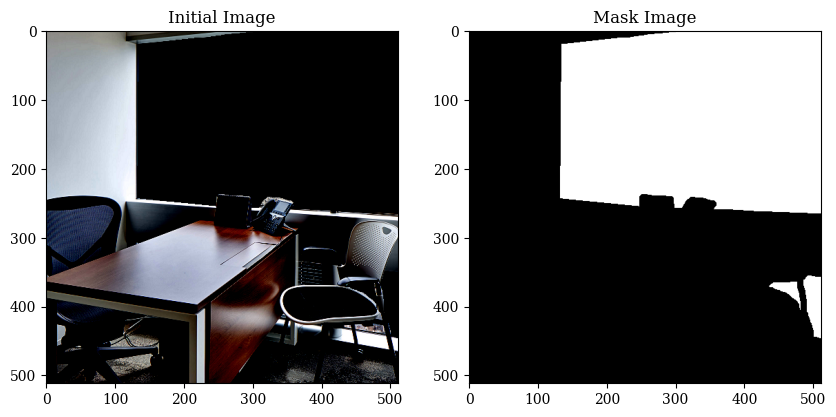

In [ ]:
def prepare_mask_and_masked(
    image: Image.Image,
    mask: Image.Image,
) -> tuple[torch.Tensor, torch.Tensor]:
  """
    Preprocesses an image and mask for deep learning models.

    Args:
        image: Input image (PIL Image)
        mask: Input mask (PIL Image)
        inverted: If True, inverts the mask values

    Returns:
        (mask_tensor, masked_image_tensor)
    """
  # Convert image to tensor and normalize
  image = np.array(image.convert("RGB"))
  image = image[None].transpose(0, 3, 1, 2)
  image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

  # Convert mask to binary tensor
  mask = np.array(mask.convert("L")).astype(np.float32) / 255.0
  mask = mask[None, None]
  mask = (mask >= 0.5).astype(np.float32)

  mask = torch.from_numpy(1 - mask)
  masked_image = image * (mask < 0.5)

  return mask, masked_image


# Load initial image
image_dir = "./images/"
image_name = "002.png"
mask_name = "002_masked.png"
init_image = plt.imread(image_dir + image_name)
mask_image = plt.imread(image_dir + mask_name)

size_2d = (512, 512)

init_image = Image.open(image_dir + image_name).convert('RGB').resize(size_2d)
mask_image = Image.open(image_dir + mask_name).convert('RGB').resize(size_2d)
# mask_image = ImageOps.invert(mask_image).resize(size_2d)

mask_image, init_image = prepare_mask_and_masked(init_image, mask_image)

# Plot the initial image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(init_image[0].permute(1, 2, 0))
axes[0].set_title("Initial Image")
# axes[0].axis("off")
axes[1].imshow(mask_image[0].permute(1, 2, 0), cmap="gray")
axes[1].set_title("Mask Image")
# axes[1].axis("off")
plt.show()

In [ ]:
# Create a PGD attack that minimizes the attention map


# Define the loss function
def loss_fn(attention_map: list[torch.Tensor]) -> torch.Tensor:
  """Loss function that minimizes the attention map."""
  total_loss = torch.tensor(0.0, device=attention_map[0].device)
  for attn_map in attention_map:
    # We want to minimize the mean of the attention map
    total_loss += torch.sum(attn_map**2)
  return total_loss


# Define the hook function on the UNet to get the attention map
def register_hook(model):
  attention_maps = []

  def hook_fn(module, input, output):
    """Hook that returns the attention map."""

    if isinstance(output, tuple):  # Handle different diffusers versions
      output = output[0]
    attention_map = torch.mean(output, dim=(0, 2))
    attention_maps.append(attention_map)

  # Register the hook
  for name, module in model.unet.named_modules():
    if "attn1" in name or "attn2" in name:  # Capture both self- and cross-attention
      # Do no register hook for the submodules of the attention module
      if "attn1." in name or "attn2." in name:
        continue
      print(f"Registering hook for {name}")
      module.register_forward_hook(hook_fn)

  return model, attention_maps


pipe_inpaint, attention_maps = register_hook(pipe_inpaint)


# Define the attack
def pgd_attack(
    image: torch.Tensor,
    mask: torch.Tensor,
    pipe: StableDiffusionInpaintPipeline,
    attention_maps: list[torch.Tensor],
    n_iter=10,
    eps=1e-2,
    device='cuda',
):
  """Runs a PGD attack on the image to minimize the attention map."""
  # Make sure we're using the right device
  device = torch.device(device)

  # Prepare the image and mask - Scale image to [0, 1] range if in [-1, 1]
  if image.min() < 0:
    image = (image + 1) / 2

  # Clone and detach the image, and make sure it requires gradients
  adv_image = image.clone().detach().to(device)
  adv_image.requires_grad_(True)

  # Ensure mask is on the correct device and doesn't require gradients
  mask = mask.clone().detach().to(device)

  # Create an optimizer for the image
  optimizer = torch.optim.Adam([adv_image], lr=eps)

  for i in range(n_iter):
    # Reset gradients
    optimizer.zero_grad()

    # Clear the attention maps for the new forward pass
    attention_maps.clear()

    # Forward pass through the model
    # We need to make a call that will trigger the hooks
    torch.set_grad_enabled(True)

    with torch.enable_grad():
      # Make sure we use the clone to avoid in-place modifications
      current_image = adv_image.clone()

      # Run the diffusion pipeline to get the latent
      with torch.no_grad():
        # Run the diffusion pipeline
        latent = pipe.encode(current_image, mask)



      # Check if we have any attention maps
      if attention_maps:
        # Compute the loss
        loss = loss_fn(attention_maps)
        print(
            f"Iteration {i+1}/{n_iter}, Loss: {loss.item()}, Maps collected: {len(attention_maps)}"
        )

        # Backpropagate
        loss.backward()

        # Update the image to minimize attention
        optimizer.step()

        # Apply the mask to keep the original content in the non-masked regions
        with torch.no_grad():
          # Make sure the image stays in [0, 1]
          adv_image.data = torch.clamp(adv_image.data, 0, 1)

          # Apply mask to keep original content in unmasked regions
          # (1 - mask) represents the mask where we want to modify the image
          adv_image.data = mask * image + (1 - mask) * adv_image.data
      else:
        print(f"Iteration {i+1}/{n_iter}: No attention maps collected")
        break

  # Return the adversarial image
  return adv_image.detach()


# Run the PGD attack
adv_image = pgd_attack(
    image=init_image,
    mask=mask_image,
    pipe=pipe_inpaint,
    attention_maps=attention_maps,
)

# Plot the adversarial image
plt.imshow(adv_image[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

Registering hook for down_blocks.0.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.0.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.0.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.0.attentions.1.transformer_blocks.0.attn2
Registering hook for down_blocks.1.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.1.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.1.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.1.attentions.1.transformer_blocks.0.attn2
Registering hook for down_blocks.2.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.2.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.2.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.2.attentions.1.transformer_blocks.0.attn2
Registering hook for up_blocks.1.attentions.0.transformer_blocks.0.attn1
Registering hook for up_blo

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1/10, Loss: 759.3859252929688, Maps collected: 1632


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn